# Project 3: Web APIs and NLP

In this project, we test our knowledge about collecting text data using Pushift's API and perform binary classification on two subreddits. 

Two subreddits selected for this project are: "Stocks" and "CryptoCurrency". These categories are very popular while they have some common words. Therefore overlaps make the classification harder than two categories without overlaps. 

For more information about these two categories, you can check them out using the following links: 

- [Subreddit category: "Stocks"](https://www.reddit.com/r/stocks/)

- [Subreddit category: "CryptoCurrency"](https://www.reddit.com/r/CryptoCurrency/)



## Classification workflow

- [Importing libraries](#import) 

- [Collecting data using `request` library and Pushift's API](#API)

- [Performing EDA](#EDA)

- [Fitting and evaluating classification models(estimators)](#Fitting)

- [Summary](#summary)

<a id='import'></a>

## Importing libraries

Here, libraries required for classifications are imported. In addition to classifiers and sikit_learn libraries, `Wordcloud` and `eli5` libraries are imported to evaluate the feature importance analysis.  

In [1]:
import requests 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# ! pip install eli5
import eli5


<a id='API'></a>
## Collecting data using `request` library and Pushift's API

Pushift's API requests are prepared for two subreddits. Since Pushift's limitation is only 100 posts per request so several requests should be made to increase number of posts for generalized classifications. Here are steps performed for data collection: 

1. Posts from "Stocks" and "CryptoCurrency" subreddits have been requested for a month starting from **Sunday, 21 March 2021 10:00:00** to **Tuesday, 20 April 2021 10:00:00 GMT**

2. Posts are requested for each category using the `message` function defined to request posts using Pushift's API.

3. Posts are converted into a dataframe and three features are extracted from them, including **subreddit, selftext, title**. 

4. Two dataframes are concatenated to make the final dataframe. This data frame will be used for classification analysis.  

In [2]:
# defining message function

utc=['1618912800','1618826400','1618740000','1618653600','1618567200','1618480800',
     '1618394400','1618308000','1618221600', '1618135200','1618048800','1617962400',
     '1617876000','1617789600','1617703200','1617616800','1617530400','1617444000',
     '1617357600','1617271200','1617184800','1617098400','1617012000','1616925600',
     '1616839200','1616752800','1616666400', '1616580000','1616493600','1616407200','1616320800']

subreddit=['CryptoCurrency','stocks']

def message(category,time):
    res_crypto=requests.get(url='https://api.pushshift.io/reddit/search/submission',
                            params={'subreddit':category,
                            'size': 100,
                            'before':time})
    
    print(res_crypto.status_code)
    data_crypto=res_crypto.json()
    df=pd.DataFrame(data_crypto['data'])[['subreddit','selftext','title']]
    return df

In [3]:
# Creating a dataframe for Cryptocurrency
df_CryptoCurrency=pd.concat([message ('CryptoCurrency',time) for time in utc])

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [4]:
# Defining a dataframe for stocks
df_stocks=pd.concat([message ('stocks',time) for time in utc])
    

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [5]:
#df_CryptoCurrency.loc[df_CryptoCurrency['selftext']=='[removed]',:].shape

In [6]:
#df_stocks.loc[df_stocks['selftext']=='[removed]',:].shape

In [7]:
# Concanating two dataframes
df_final=pd.concat([df_CryptoCurrency,df_stocks])

<a id='EDA'></a>
## Performing EDA


Now, the final dataframe composed of two subreddit posts is evaluated using EDA analysis. Steps taken for EDS analysis are: 

1. The subreddit column is mapped in numeric values as **"CryptoCurrency":0** and **"Stocks":1**. 

2. The number of null cells in **'title'** and **'selftext'** columns are counted and dropped from the dataframe. This is reasonable because there are only 27 null cells in **'selftext'** column.

3. The most frequent words in **'title'** and **'selftext'** column are visualized using the `WordCloud` library.   
  

In [8]:
# Mapping categorical data into 0 and 1

df_final['subreddit']=df_final['subreddit'].map({"CryptoCurrency":0,"stocks":1})

In [9]:
# Investigaging how many null cells are in 'selftext' column.
df_final['selftext'].isnull().sum()

27

In [10]:
# Dropping null rows of selftext column
df_final['selftext'].dropna(inplace=True)

In [11]:
# Investigating how many null cells are in the 'title' column 
df_final['title'].isnull().sum()

0

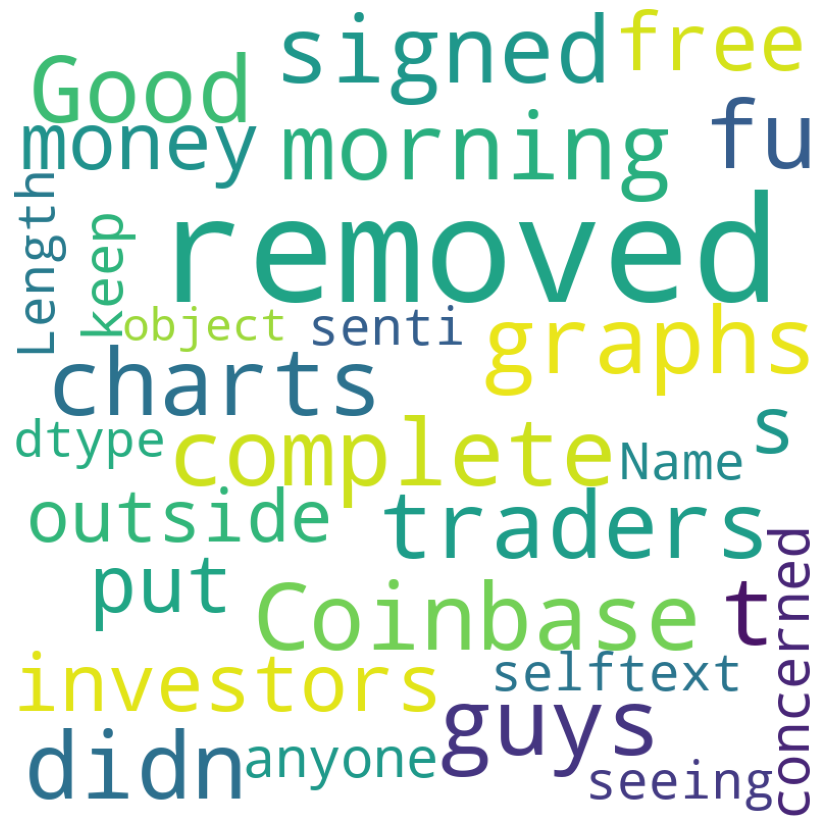

In [14]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(df_final['selftext']))
plt.figure(figsize=(15,15),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
#plt.show()
plt.savefig('images/word_cloud_selftext.png', dpi=600);

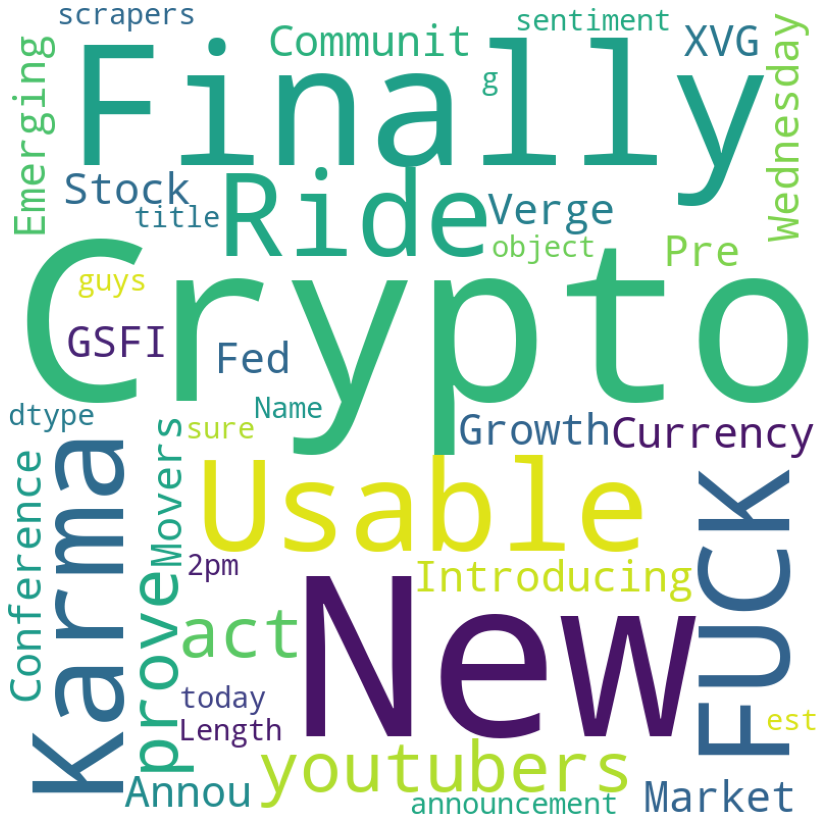

In [15]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(df_final['title']))

plt.figure(figsize=(15,15),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
#plt.show()
plt.savefig('images/word_cloud_title.png', dpi=600)

<a id=Fitting></a>
## Fitting and evaluating classification models(estimators) 

Now, we can fit different classifiers to the final dataframe and evaluate their performances. Here are the steps taken to fit and evaluate a model: 

1. **selftext** column is defined as **X** variable and **subreddit** column (having 0 and 1 values) is defined as **y** variable. 
2. Training and test sets are split using `train_test_split` library with the test size of %30.
3. Before performing any hyperparameter and pipeline analysis, data type of **X** variable should be converted to Unicode or string. If datatype is  object, it would throw an error.
4. To evaluate a chain of transformers and estimators for different hyperparameters, `Pipeline()` and `GridSearchCV()` are used. 
5. 7 pipelines are used to fit the training dataset and evaluate its performance on the test dataset. 
6. The following table summarizes the main hyperparameters evaluated for each pipeline.

|Pipeline No.| Transformer|Transformer Hyperparameters|Estimator|Estimator Hyperparameters|
|:-------------------:|:--------------:|:-------:|:----------:|:-----------------:|
|1| `CountVectorizer()`|max_df=0.8, max_features=2000, min_df=2, stop_words='english'|`LogisticRegression()`|C=5, solver='saga'| 
|2|`TfidfVectorizer()`|max_df=0.8, max_features=1000, min_df=2, stop_words='english'|`LogisticRegression()`|C=10, solver='saga'|
|3|`TfidfVectorizer()`|max_df=0.8, max_features=100, min_df=3, stop_words='english'|`knn()`|n_neighbors=4|
|4|`TfidfVectorizer()`|max_df=0.9, max_features=100, min_df=2, ngram_range=(1, 2), stop_words='english'|`DecisionTreeClassifier()`|max_depth=7, min_samples_leaf=3,min_samples_split=3|
|5|`TfidfVectorizer()`|max_df=0.8, max_features=2000, min_df=2, stop_words='english'|`SVC()`|C=1|
|6|`TfidfVectorizer()`|max_df=0.8, max_features=100, min_df=2, stop_words='english'|`BernoulliNB()`||
|7|`TfidfVectorizer()`|max_df=0.9, max_features=1000, min_df=3, stop_words='english'|`RandomForestClassifier()`|n_estimators=200|
   

                
7. (i) Best training score based on CV, (ii) training score, (iii) test score, (iv) confusion matrix, and (v) feature importance parameter (`eli5` library) based on best estimator for each pipeline are calculated.   


In [16]:
# Defining X and y datasets
#X=df_final[['selftext','title']]
X=df_final['selftext']

y=df_final['subreddit']

In [17]:
print (f" the size of X is:{X.shape}")
print (f" the size of y is:{y.shape}")
       

 the size of X is:(6200,)
 the size of y is:(6200,)


In [18]:
# Split train/test sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [19]:
# Casting datatype as Unicode or Object.
X_train=X_train.astype('U')
X_test=X_test.astype('U')
#X_train.values.astype('U')

### 1. Pipeline and Grid Searching: **Logistic Regreesion and CountVectorizer()** 

In [20]:
pipe_1=Pipeline([
    ('cvec',CountVectorizer()),
    ('lr',LogisticRegression())
])

pipe_params = {
    'cvec__max_features':[100,1000,2000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.8,0.9],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':[None,'english'],
    "lr__penalty": [None,'l1','l2'],
    "lr__solver":['saga'],
    'lr__C':[1,5,10]
    
}

gs_cvec_lr = GridSearchCV(pipe_1, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_cvec_lr.fit(X_train,y_train)
gs_cvec_lr_model=gs_cvec_lr.best_estimator_

print (f" The best estimator for Pipeline_1 is : {gs_cvec_lr.best_estimator_}")


print(f" Best Score based on CV: {gs_cvec_lr.best_score_}")


print(f" Training Score: {gs_cvec_lr_model.score(X_train,y_train)}")


print(f" Test Score: {gs_cvec_lr_model.score(X_test,y_test)}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  8.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


 The best estimator for Pipeline_1 is : Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression(C=5, penalty='l1', solver='saga'))])
 Best Score based on CV: 0.8112903225806452
 Training Score: 0.8172811059907834
 Test Score: 0.8032258064516129


In [21]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_cvec_lr_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'],
                   index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 601                352
actural Stocks (+ve)                 14                893
Sensitivity: 0.98
Specificity: 0.63


In [22]:
pd.DataFrame(gs_cvec_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_lr__C,...,param_lr__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.359839,0.016823,0.000000,0.000000,0.8,100,2,"(1, 1)",None,1,...,saga,"{'cvec__max_df': 0.8, 'cvec__max_features': 10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
1,0.691551,0.019581,0.054454,0.002053,0.8,100,2,"(1, 1)",None,1,...,saga,"{'cvec__max_df': 0.8, 'cvec__max_features': 10...",0.755760,0.741935,0.761521,0.768433,0.740783,0.753687,0.010842,400
2,0.403121,0.066271,0.054654,0.006445,0.8,100,2,"(1, 1)",None,1,...,saga,"{'cvec__max_df': 0.8, 'cvec__max_features': 10...",0.756912,0.741935,0.761521,0.769585,0.743088,0.754608,0.010684,374
3,0.272073,0.025060,0.000000,0.000000,0.8,100,2,"(1, 1)",None,5,...,saga,"{'cvec__max_df': 0.8, 'cvec__max_features': 10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,448
4,0.593213,0.024635,0.057447,0.005224,0.8,100,2,"(1, 1)",None,5,...,saga,"{'cvec__max_df': 0.8, 'cvec__max_features': 10...",0.756912,0.741935,0.761521,0.769585,0.743088,0.754608,0.010684,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,4.719446,0.280382,0.122703,0.011509,0.9,2000,3,"(1, 3)",english,5,...,saga,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.804147,0.802995,0.822581,0.829493,0.794931,0.810829,0.013002,14
644,1.892964,0.119976,0.138206,0.013616,0.9,2000,3,"(1, 3)",english,5,...,saga,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.802995,0.804147,0.822581,0.829493,0.794931,0.810829,0.013002,14
645,1.324403,0.085879,0.000000,0.000000,0.9,2000,3,"(1, 3)",english,10,...,saga,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,453
646,4.071430,0.195159,0.062344,0.009732,0.9,2000,3,"(1, 3)",english,10,...,saga,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.804147,0.802995,0.822581,0.829493,0.794931,0.810829,0.013002,14


In [23]:
# Feature importance analysis based on the best estimator obtained from Pipeline_1

cvec_FI=CountVectorizer(max_df=0.8,max_features=2000, min_df=2, stop_words='english')

X_train_cvec_FI=cvec_FI.fit_transform(X_train)
#X_train_cvec.toarray()

X_test_cvec_FI=cvec_FI.transform(X_test)

lr_FI=LogisticRegression(C=5, solver='saga')
lr_FI.fit(X_train_cvec_FI,y_train)
#lr.score(X_train_cvec,y_train)
#lr.score(X_test_cvec,y_test)

eli5.explain_weights(lr_FI,top=50, feature_names=cvec_FI.get_feature_names())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Weight?,Feature
+0.624,removed
+0.404,stock
+0.379,stocks
+0.273,company
+0.223,shares
+0.170,companies
+0.115,share
+0.105,growth
+0.099,news
+0.098,year


### 2. Pipeline and Grid Searching: **Logistic Regreesion and TF-IDF()**

In [24]:
 pipe_2=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
    "lr__penalty": [None,'l1','l2'],
    "lr__solver":['saga'],
    'lr__C':[1,5,10]
    
}

gs_tvec_lr = GridSearchCV(pipe_2, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_lr.fit(X_train,y_train)
gs_tvec_lr_model=gs_tvec_lr.best_estimator_

print (f" The best estimator for Pipeline_2 is : {gs_tvec_lr.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_lr.best_score_}")


print(f" Training Score: {gs_tvec_lr_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_lr_model.score(X_test,y_test)}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  7.5min finished


 The best estimator for Pipeline_2 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=1000, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression(C=10, solver='saga'))])
 Best Score based on CV: 0.809447004608295
 Training Score: 0.8253456221198157
 Test Score: 0.8032258064516129


In [25]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_lr_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 606                347
actural Stocks (+ve)                 19                888
Sensitivity: 0.98
Specificity: 0.64


In [26]:
pd.DataFrame(gs_tvec_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_lr__solver,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,...,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.285339,0.020446,0.000000,0.000000,1,None,saga,0.8,100,2,...,None,"{'lr__C': 1, 'lr__penalty': None, 'lr__solver'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
1,0.324641,0.036306,0.000000,0.000000,1,None,saga,0.8,100,2,...,english,"{'lr__C': 1, 'lr__penalty': None, 'lr__solver'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,502
2,1.427207,0.067132,0.000000,0.000000,1,None,saga,0.8,100,2,...,None,"{'lr__C': 1, 'lr__penalty': None, 'lr__solver'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,501
3,1.021295,0.090360,0.000000,0.000000,1,None,saga,0.8,100,2,...,english,"{'lr__C': 1, 'lr__penalty': None, 'lr__solver'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,500
4,3.081270,0.141461,0.000000,0.000000,1,None,saga,0.8,100,2,...,None,"{'lr__C': 1, 'lr__penalty': None, 'lr__solver'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,0.441972,0.035564,0.072587,0.011656,10,l2,saga,0.9,2000,3,...,english,"{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver...",0.797235,0.800691,0.820276,0.826037,0.792627,0.807373,0.013264,28
644,1.692782,0.122121,0.158485,0.022837,10,l2,saga,0.9,2000,3,...,None,"{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver...",0.799539,0.792627,0.822581,0.817972,0.788018,0.804147,0.013748,122
645,1.247559,0.184820,0.123321,0.023156,10,l2,saga,0.9,2000,3,...,english,"{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver...",0.797235,0.801843,0.822581,0.822581,0.793779,0.807604,0.012493,19
646,2.650415,0.086934,0.097626,0.011520,10,l2,saga,0.9,2000,3,...,None,"{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver...",0.797235,0.796083,0.823733,0.820276,0.788018,0.805069,0.014230,92


In [27]:
# Feature importance analysis based on the best estimator obtained from Pipeline_2

tvec_FI=TfidfVectorizer(max_df=0.8, max_features=2000, min_df=2, stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

lr_tvec_FI=LogisticRegression(C=10, solver='saga')
lr_tvec_FI.fit(X_train_cvec_FI,y_train)


eli5.explain_weights(lr_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Weight?,Feature
+0.623,removed
+0.404,stock
+0.378,stocks
+0.272,company
+0.223,shares
+0.171,companies
+0.115,share
+0.105,growth
+0.099,year
+0.099,portfolio


### 3. Pipeline and Grid Searching: **KNN and TF-IDF()** 

In [28]:
pipe_3=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('knn',KNeighborsClassifier())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
    "knn__n_neighbors": [4,5,6],
    "knn__p":[1,2]
    
}

gs_tvec_knn = GridSearchCV(pipe_3, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_knn.fit(X_train,y_train)
gs_tvec_knn_model=gs_tvec_knn.best_estimator_

print (f" The best estimator for Pipeline_3 is : {gs_tvec_knn.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_knn.best_score_}")


print(f" Training Score: {gs_tvec_knn_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_knn_model.score(X_test,y_test)}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  6.1min finished


 The best estimator for Pipeline_3 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=100, min_df=3,
                                 stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=4))])
 Best Score based on CV: 0.7301843317972351
 Training Score: 0.784331797235023
 Test Score: 0.7559139784946236


In [29]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_knn_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 602                351
actural Stocks (+ve)                103                804
Sensitivity: 0.89
Specificity: 0.63


In [30]:
pd.DataFrame(gs_tvec_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.310169,0.016627,0.395241,0.010647,4,1,0.8,100,2,"(1, 1)",None,"{'knn__n_neighbors': 4, 'knn__p': 1, 'tvec__ma...",0.717742,0.564516,0.746544,0.730415,0.718894,0.695622,0.066367,65
1,0.302986,0.028493,0.283297,0.039106,4,1,0.8,100,2,"(1, 1)",english,"{'knn__n_neighbors': 4, 'knn__p': 1, 'tvec__ma...",0.722350,0.552995,0.740783,0.723502,0.695853,0.687097,0.068572,103
2,1.317220,0.060477,0.444940,0.017618,4,1,0.8,100,2,"(1, 2)",None,"{'knn__n_neighbors': 4, 'knn__p': 1, 'tvec__ma...",0.717742,0.562212,0.745392,0.726959,0.550691,0.660599,0.085579,253
3,1.122656,0.188495,0.320983,0.033862,4,1,0.8,100,2,"(1, 2)",english,"{'knn__n_neighbors': 4, 'knn__p': 1, 'tvec__ma...",0.724654,0.557604,0.737327,0.724654,0.700461,0.688940,0.066745,89
4,2.696083,0.136186,0.518899,0.016125,4,1,0.8,100,2,"(1, 3)",None,"{'knn__n_neighbors': 4, 'knn__p': 1, 'tvec__ma...",0.717742,0.562212,0.745392,0.726959,0.550691,0.660599,0.085579,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.408348,0.078576,0.328547,0.041983,6,2,0.9,2000,3,"(1, 1)",english,"{'knn__n_neighbors': 6, 'knn__p': 2, 'tvec__ma...",0.679724,0.521889,0.700461,0.692396,0.508065,0.620507,0.086529,429
428,1.804321,0.201993,0.472617,0.060836,6,2,0.9,2000,3,"(1, 2)",None,"{'knn__n_neighbors': 6, 'knn__p': 2, 'tvec__ma...",0.687788,0.526498,0.705069,0.699309,0.516129,0.626959,0.086500,407
429,1.146953,0.121170,0.367215,0.047257,6,2,0.9,2000,3,"(1, 2)",english,"{'knn__n_neighbors': 6, 'knn__p': 2, 'tvec__ma...",0.679724,0.521889,0.701613,0.692396,0.670507,0.653226,0.066522,307
430,3.035126,0.087365,0.328050,0.161910,6,2,0.9,2000,3,"(1, 3)",None,"{'knn__n_neighbors': 6, 'knn__p': 2, 'tvec__ma...",0.687788,0.527650,0.706221,0.700461,0.677419,0.659908,0.066881,261


In [31]:
# Feature importance analysis based on the best estimator obtained from Pipeline_3
tvec_FI=TfidfVectorizer(max_df=0.8, max_features=100, min_df=3,stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

knn_tvec_FI=KNeighborsClassifier(n_neighbors=4)
knn_tvec_FI.fit(X_train_cvec_FI,y_train)


eli5.explain_weights(knn_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())

Explanation(estimator='KNeighborsClassifier(n_neighbors=4)', description=None, error='estimator KNeighborsClassifier(n_neighbors=4) is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### 4. Pipeline and Grid Searching: **DecisionTrees and TF-IDF()**


In [32]:
pipe_4=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('dt',DecisionTreeClassifier())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
    "dt__max_depth": [3,5,7],
    "dt__min_samples_leaf":[3,5],
    "dt__min_samples_split":[3,7,10]
    
}

gs_tvec_dt = GridSearchCV(pipe_4, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_dt.fit(X_train,y_train)
gs_tvec_dt_model=gs_tvec_dt.best_estimator_

print (f" The best estimator for Pipeline_4 is : {gs_tvec_dt.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_dt.best_score_}")


print(f" Training Score: {gs_tvec_dt_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_dt_model.score(X_test,y_test)}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 13.5min finished


 The best estimator for Pipeline_4 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=100, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('dt',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=3,
                                        min_samples_split=3))])
 Best Score based on CV: 0.7794930875576036
 Training Score: 0.7861751152073733
 Test Score: 0.7725806451612903


In [33]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_dt_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 603                350
actural Stocks (+ve)                 73                834
Sensitivity: 0.92
Specificity: 0.63


In [34]:
pd.DataFrame(gs_tvec_dt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__max_depth,param_dt__min_samples_leaf,param_dt__min_samples_split,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,...,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.311109,0.051043,0.061577,0.010192,3,3,3,0.8,100,2,...,None,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.740783,0.746544,0.761521,0.759217,0.736175,0.748848,0.009991,944
1,0.304016,0.027349,0.061079,0.011725,3,3,3,0.8,100,2,...,english,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.739631,0.746544,0.762673,0.755760,0.735023,0.747926,0.010159,1013
2,1.368758,0.053943,0.130599,0.014020,3,3,3,0.8,100,2,...,None,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.741935,0.746544,0.762673,0.759217,0.736175,0.749309,0.010112,868
3,1.038170,0.099902,0.117049,0.032929,3,3,3,0.8,100,2,...,english,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.740783,0.745392,0.762673,0.755760,0.735023,0.747926,0.010028,1013
4,3.054546,0.252913,0.197180,0.028303,3,3,3,0.8,100,2,...,None,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.740783,0.746544,0.763825,0.759217,0.736175,0.749309,0.010599,868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,0.301589,0.019670,0.064228,0.011294,7,5,10,0.9,2000,3,...,english,"{'dt__max_depth': 7, 'dt__min_samples_leaf': 5...",0.762673,0.766129,0.791475,0.783410,0.758065,0.772350,0.012841,255
1292,1.326851,0.111245,0.141422,0.030319,7,5,10,0.9,2000,3,...,None,"{'dt__max_depth': 7, 'dt__min_samples_leaf': 5...",0.760369,0.760369,0.786866,0.784562,0.754608,0.769355,0.013542,476
1293,0.966814,0.072417,0.104123,0.019076,7,5,10,0.9,2000,3,...,english,"{'dt__max_depth': 7, 'dt__min_samples_leaf': 5...",0.762673,0.766129,0.791475,0.781106,0.754608,0.771198,0.013288,313
1294,2.464808,0.067459,0.118283,0.041852,7,5,10,0.9,2000,3,...,None,"{'dt__max_depth': 7, 'dt__min_samples_leaf': 5...",0.760369,0.760369,0.785714,0.782258,0.755760,0.768894,0.012485,507


In [35]:
# Feature importance analysis based on the best estimator obtained from Pipeline_4
  
tvec_FI=TfidfVectorizer(max_df=0.9, max_features=100, min_df=2, ngram_range=(1, 2), stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

dt_tvec_FI=DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=3)
dt_tvec_FI.fit(X_train_tvec_FI,y_train)


eli5.explain_weights(dt_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())


Weight,Feature
0.2946,stock
0.2750,removed
0.1344,stocks
0.1035,company
0.0456,crypto
0.0448,companies
0.0316,year
0.0273,shares
0.0128,binance
0.0091,coin


### 5. Pipeline and Grid Searching: Support Vector Machines and TF-IDF()

In [36]:
pipe_5=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('svc',SVC())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
    "svc__C": [1,50,100],
    "svc__kernel":['linear','rbf','poly']
    
}


gs_tvec_svc = GridSearchCV(pipe_5, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_svc.fit(X_train,y_train)
gs_tvec_svc_model=gs_tvec_svc.best_estimator_

print (f" The best estimator for Pipeline_5 is : {gs_tvec_svc.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_svc.best_score_}")


print(f" Training Score: {gs_tvec_svc_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_svc_model.score(X_test,y_test)}")



Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 13.6min finished


 The best estimator for Pipeline_5 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=2000, min_df=2,
                                 stop_words='english')),
                ('svc', SVC(C=1))])
 Best Score based on CV: 0.8131336405529954
 Training Score: 0.8253456221198157
 Test Score: 0.8026881720430108


In [37]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_svc_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 603                350
actural Stocks (+ve)                 17                890
Sensitivity: 0.98
Specificity: 0.63


In [38]:
pd.DataFrame(gs_tvec_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.819598,0.024832,0.135242,0.007042,1,linear,0.8,100,2,"(1, 1)",None,"{'svc__C': 1, 'svc__kernel': 'linear', 'tvec__...",0.759217,0.759217,0.779954,0.784562,0.753456,0.767281,0.012493,493
1,0.544348,0.019997,0.082777,0.007272,1,linear,0.8,100,2,"(1, 1)",english,"{'svc__C': 1, 'svc__kernel': 'linear', 'tvec__...",0.790323,0.788018,0.813364,0.807604,0.771889,0.794240,0.014818,357
2,1.670732,0.078589,0.203856,0.016601,1,linear,0.8,100,2,"(1, 2)",None,"{'svc__C': 1, 'svc__kernel': 'linear', 'tvec__...",0.752304,0.752304,0.782258,0.777650,0.751152,0.763134,0.013817,531
3,1.105243,0.050867,0.114295,0.011675,1,linear,0.8,100,2,"(1, 2)",english,"{'svc__C': 1, 'svc__kernel': 'linear', 'tvec__...",0.791475,0.789171,0.815668,0.804147,0.773041,0.794700,0.014415,353
4,2.991396,0.110967,0.301993,0.039479,1,linear,0.8,100,2,"(1, 3)",None,"{'svc__C': 1, 'svc__kernel': 'linear', 'tvec__...",0.752304,0.752304,0.782258,0.777650,0.751152,0.763134,0.013817,531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1.836682,0.146126,0.285391,0.018584,100,poly,0.9,2000,3,"(1, 1)",english,"{'svc__C': 100, 'svc__kernel': 'poly', 'tvec__...",0.715438,0.725806,0.748848,0.741935,0.709677,0.728341,0.015011,637
644,3.934689,0.220303,0.586709,0.043945,100,poly,0.9,2000,3,"(1, 2)",None,"{'svc__C': 100, 'svc__kernel': 'poly', 'tvec__...",0.741935,0.753456,0.774194,0.762673,0.738479,0.754147,0.013188,561
645,2.742197,0.127116,0.297802,0.013463,100,poly,0.9,2000,3,"(1, 2)",english,"{'svc__C': 100, 'svc__kernel': 'poly', 'tvec__...",0.715438,0.725806,0.748848,0.743088,0.711982,0.729032,0.014671,625
646,4.695347,0.510205,0.489244,0.069870,100,poly,0.9,2000,3,"(1, 3)",None,"{'svc__C': 100, 'svc__kernel': 'poly', 'tvec__...",0.741935,0.752304,0.774194,0.762673,0.740783,0.754378,0.012692,557


In [39]:
# Feature importance analysis based on the best estimator obtained from Pipeline_5
              
tvec_FI=TfidfVectorizer(max_df=0.8, max_features=2000, min_df=2, stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

svc_tvec_FI=SVC(C=1,kernel='linear')
svc_tvec_FI.fit(X_train_tvec_FI,y_train)


eli5.explain_weights(svc_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())


Weight?,Feature
+3.209,stock
+3.046,stocks
+2.383,company
+1.999,removed
+1.998,shares
+1.981,companies
+1.691,etf
+1.618,tech
+1.585,investing
+1.537,missing


### 6. Pipeline and Grid Searching: Naive  and TF-IDF() 

In [40]:
pipe_6=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('nb',BernoulliNB())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
 
}


gs_tvec_nb = GridSearchCV(pipe_6, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_nb.fit(X_train,y_train)
gs_tvec_nb_model=gs_tvec_nb.best_estimator_

print (f" The best estimator for Pipeline_6 is : {gs_tvec_nb.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_nb.best_score_}")


print(f" Training Score: {gs_tvec_nb_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_nb_model.score(X_test,y_test)}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   41.9s finished


 The best estimator for Pipeline_6 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=100, min_df=2,
                                 stop_words='english')),
                ('nb', BernoulliNB())])
 Best Score based on CV: 0.7930875576036867
 Training Score: 0.7976958525345622
 Test Score: 0.7887096774193548


In [41]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_nb_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 600                353
actural Stocks (+ve)                 40                867
Sensitivity: 0.96
Specificity: 0.63


In [42]:
pd.DataFrame(gs_tvec_nb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.266078,0.011885,0.058843,0.006880,0.8,100,2,"(1, 1)",None,"{'tvec__max_df': 0.8, 'tvec__max_features': 10...",0.762673,0.758065,0.788018,0.777650,0.758065,0.768894,0.011964,13
1,0.262499,0.011360,0.054454,0.007372,0.8,100,2,"(1, 1)",english,"{'tvec__max_df': 0.8, 'tvec__max_features': 10...",0.785714,0.782258,0.808756,0.808756,0.779954,0.793088,0.012924,1
2,1.213754,0.072195,0.114894,0.010140,0.8,100,2,"(1, 2)",None,"{'tvec__max_df': 0.8, 'tvec__max_features': 10...",0.754608,0.750000,0.778802,0.775346,0.754608,0.762673,0.011928,17
3,0.900394,0.051259,0.088962,0.010448,0.8,100,2,"(1, 2)",english,"{'tvec__max_df': 0.8, 'tvec__max_features': 10...",0.784562,0.778802,0.806452,0.804147,0.779954,0.790783,0.012030,9
4,2.576709,0.044560,0.167552,0.020214,0.8,100,2,"(1, 3)",None,"{'tvec__max_df': 0.8, 'tvec__max_features': 10...",0.754608,0.750000,0.778802,0.775346,0.754608,0.762673,0.011928,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.300393,0.008932,0.070611,0.013252,0.9,2000,3,"(1, 1)",english,"{'tvec__max_df': 0.9, 'tvec__max_features': 20...",0.634793,0.629032,0.644009,0.644009,0.633641,0.637097,0.005964,29
68,1.428978,0.195149,0.135239,0.011400,0.9,2000,3,"(1, 2)",None,"{'tvec__max_df': 0.9, 'tvec__max_features': 20...",0.631336,0.629032,0.642857,0.640553,0.631336,0.635023,0.005568,53
69,0.963624,0.122882,0.099734,0.007846,0.9,2000,3,"(1, 2)",english,"{'tvec__max_df': 0.9, 'tvec__max_features': 20...",0.633641,0.633641,0.642857,0.642857,0.634793,0.637558,0.004347,25
70,2.480366,0.061273,0.104719,0.013455,0.9,2000,3,"(1, 3)",None,"{'tvec__max_df': 0.9, 'tvec__max_features': 20...",0.634793,0.627880,0.642857,0.638249,0.630184,0.634793,0.005404,57


In [43]:
# Feature importance analysis based on the best estimator obtained from Pipeline_6
              
tvec_FI=TfidfVectorizer(max_df=0.8, max_features=100, min_df=2, stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

nb_tvec_FI=BernoulliNB()
nb_tvec_FI.fit(X_train_tvec_FI,y_train)


eli5.explain_weights(nb_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())


Explanation(estimator='BernoulliNB()', description=None, error='estimator BernoulliNB() is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### 7. Pipeline and Grid Searching:  Random Forests and TF-IDF()



In [44]:
pipe_7=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('rf',RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features':[100,1000,2000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.8,0.9],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[None,'english'],
    'rf__n_estimators':[100,200,300],
    "rf__max_depth":[None,1,5,10]
 
}


gs_tvec_rf = GridSearchCV(pipe_7, 
                  param_grid=pipe_params, 
                  cv=5,
                 n_jobs=-1,
                 verbose=1)

gs_tvec_rf.fit(X_train,y_train)
gs_tvec_rf_model=gs_tvec_rf.best_estimator_

print (f" The best estimator for Pipeline_7 is : {gs_tvec_rf.best_estimator_}")


print(f" Best Score based on CV: {gs_tvec_rf.best_score_}")


print(f" Training Score: {gs_tvec_rf_model.score(X_train,y_train)}")


print(f" Test Score: {gs_tvec_rf_model.score(X_test,y_test)}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 13.0min finished


 The best estimator for Pipeline_7 is : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=1000, min_df=3)),
                ('rf', RandomForestClassifier(n_estimators=300))])
 Best Score based on CV: 0.811520737327189
 Training Score: 0.8258064516129032
 Test Score: 0.8


In [45]:
#Calculating confusion matrix, sentivitiy and specificity 
y_pred=gs_tvec_rf_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)

df_cm=pd.DataFrame(cm, columns=['pred Crypto (-ve)', 'pred Stocks (+ve)'], index=['actual Crypto (-ve)','actural Stocks (+ve)'])

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()

print (df_cm)

print (f"Sensitivity: {round(tp/(tp+fn),2)}")

print (f"Specificity: {round(tn/(tn+fp),2)}")

                      pred Crypto (-ve)  pred Stocks (+ve)
actual Crypto (-ve)                 605                348
actural Stocks (+ve)                 24                883
Sensitivity: 0.97
Specificity: 0.63


In [46]:
pd.DataFrame(gs_tvec_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.988164,0.020344,0.081813,0.002962,None,100,0.8,100,2,"(1, 1)",None,"{'rf__max_depth': None, 'rf__n_estimators': 10...",0.785714,0.781106,0.808756,0.798387,0.775346,0.789862,0.012118,561
1,0.770340,0.044184,0.076197,0.004910,None,100,0.8,100,2,"(1, 1)",english,"{'rf__max_depth': None, 'rf__n_estimators': 10...",0.794931,0.792627,0.817972,0.814516,0.789171,0.801843,0.011951,352
2,1.899147,0.088549,0.153594,0.019534,None,100,0.8,100,2,"(1, 2)",None,"{'rf__max_depth': None, 'rf__n_estimators': 10...",0.776498,0.782258,0.805300,0.806452,0.779954,0.790092,0.013022,552
3,1.291232,0.045224,0.108864,0.010254,None,100,0.8,100,2,"(1, 2)",english,"{'rf__max_depth': None, 'rf__n_estimators': 10...",0.792627,0.791475,0.817972,0.815668,0.790323,0.801613,0.012459,359
4,3.087228,0.114992,0.199867,0.032753,None,100,0.8,100,2,"(1, 3)",None,"{'rf__max_depth': None, 'rf__n_estimators': 10...",0.779954,0.785714,0.807604,0.806452,0.778802,0.791705,0.012733,506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1.357972,0.049927,0.129450,0.017106,10,300,0.9,2000,3,"(1, 1)",english,"{'rf__max_depth': 10, 'rf__n_estimators': 300,...",0.794931,0.805300,0.826037,0.816820,0.789171,0.806452,0.013593,180
860,2.507893,0.139473,0.221608,0.035343,10,300,0.9,2000,3,"(1, 2)",None,"{'rf__max_depth': 10, 'rf__n_estimators': 300,...",0.794931,0.801843,0.829493,0.813364,0.788018,0.805530,0.014616,216
861,1.837486,0.043868,0.162365,0.009657,10,300,0.9,2000,3,"(1, 2)",english,"{'rf__max_depth': 10, 'rf__n_estimators': 300,...",0.792627,0.802995,0.827189,0.821429,0.788018,0.806452,0.015474,180
862,3.310352,0.188455,0.170357,0.065119,10,300,0.9,2000,3,"(1, 3)",None,"{'rf__max_depth': 10, 'rf__n_estimators': 300,...",0.796083,0.805300,0.828341,0.816820,0.794931,0.808295,0.012738,65


In [47]:
# Feature importance analysis based on the best estimator obtained from Pipeline_7
     
tvec_FI=TfidfVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english')

X_train_tvec_FI=tvec_FI.fit_transform(X_train)

X_test_tvec_FI=tvec_FI.transform(X_test)

rf_tvec_FI=RandomForestClassifier(n_estimators=200)
rf_tvec_FI.fit(X_train_tvec_FI,y_train)


eli5.explain_weights(rf_tvec_FI,top=50, feature_names=tvec_FI.get_feature_names())


Weight,Feature
0.2839 ± 0.1378,removed
0.0507 ± 0.1028,crypto
0.0466 ± 0.0863,stock
0.0327 ± 0.0644,stocks
0.0229 ± 0.0511,company
0.0136 ± 0.0368,coins
0.0133 ± 0.0329,shares
0.0109 ± 0.0251,companies
0.0094 ± 0.0290,bitcoin
0.0082 ± 0.0232,binance


<a id='summary'></a>
## Summary

1. **Important features based on the pipelines 1 and 2 (`LogisticRegression()`)**:
- Important features with positive and negative signs are related to Stocks and Cryptocurrency categories, respectively. 
- Top five positive parameters in pipeline 1 are removed (+0.623), stock (+0.403), stocks (+0.378), company(+0.265), and shares(+0.272).

- Top five negative parameters in pipeline 1 are cryptos (-0.640), coins (-0.269), bitcoin(-0.251), binance(-0.219), and btc(-0.183). 

- Top five positive parameters in pipeline 2 are removed (+0.623), stock (+0.404), stocks (+0.379), company (+0.274), and shares (+0.218).

- Top five negative parameters in pipeline 2 are btc(-0.183), binance(-0.210), bitcoin(-0.254), coins(-0.270), and crypto(-0.640).
 
 

2. **Important features based on the pipeline 3 (`knn`)**:
- Eli5 library does not support the knn estimator. So, feature importance table can not be generated for this estimator.

3. **Important features based on the pipeline 4 (`DecisionTreeClassifier`)**:
- Top five parameters in pipeline 4 are stock (0.2946), removed (0.2750), stocks (0.1344), company (0.1035), and crypto (0.0462).

4. **Important features based on the pipeline 5 (`SVC`)**:

- Top five positive parameters in pipeline 5 are stock (+3.209), stocks (+3.046), company (+2.383), removed (+1.999), and shares (+1.998).
- Top five negative parameters in pipeline 5 are binance(-1.743), btc (-1.785), bitcoin (-1.982), coins (-2.162), and crypto (-4.372)

5. **Important features based on the pipeline 6 (Naive, `BernoulliNB`)**:
- Eli5 library does not support the Naive estimator. So, feature importance table can not be generated for this estimator.

6. **Important features based on the pipeline 7 (`RandomForestClassifier`)**:
- Top six parameters in pipeline 7 are removed (0.2853 ± 0.1299), crypto (0.0446 ± 0.1062), stock (0.0425 ± 0.0771), stocks (0.0306 ± 0.0619), company (0.0244 ± 0.0495), and coins (0.0170 ± 0.0379). 


7. The following table summarizes the score values for different combination of transformaers and estimators.


|Pipeline No.| Transformer|Estimator|Best Score based on CV|Training Score|Test Score|
|:-------------------:|:--------------:|:-------:|:----------:|:-----------------:|:----------:|
|1| `CountVectorizer()`|`LogisticRegression()`|0.8110599078341014|0.8175115207373271|0.8032258064516129|
|2|`TfidfVectorizer()`|`LogisticRegression()`|0.809447004608295|0.8253456221198157|0.8032258064516129|
|3|`TfidfVectorizer()`|`knn()`|0.7301843317972351|0.784331797235023|0.7559139784946236|
|4|`TfidfVectorizer()`|`DecisionTreeClassifier()`|0.7301843317972351|0.784331797235023|0.7559139784946236|
|5|`TfidfVectorizer()`|`SVC()`|0.8131336405529954|0.8253456221198157|0.8026881720430108|
|6|`TfidfVectorizer()`|`BernoulliNB()`|0.7930875576036867|0.7976958525345622|0.7887096774193548|
|7|`TfidfVectorizer()`|`RandomForestClassifier()`|0.8112903225806452|0.8258064516129032|0.8010752688172043|


8. *LogisticRegression*, *SVM*, and *Random Forest* classifiers show the best score values. The best score values based on CV do not change significantly among these estimators. All three estimators have the best score value of 0.81. Interestingly, the score values obtained from these estimators for the test dataset are close to 0.8. This shows that the model is fitted properly. Moreover, the score values of the training dataset for these estimators are in the range 0.81-0.82, indicating that the over fitting issue does not exist. 

9. Confusion matrices calculated for all estimators show that sensitivity values are in the range of 0.89-0.98 while specificity values are approximately 0.63. This means that, the number of false negative values (wrongly predicted Crypto subreddit) is low while the number of false positive values (wrongly predicted stocks subreddit) is relatively high. One reason can be related to application of stocks words in crypto subreddit. However, application of crypto words in stocks is limited, leading to low false negative and high sensitivity value. 

10. High number of true positive and true negative values indicates that there are many unique words in these categories. Therefore, estimators can easily distinguish between these categories.  

